In [1]:
import csv
import cv2
import numpy as np
import sklearn
import time

In [2]:
_time = time.time()
lines = []
with open("data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
print("lines",len(lines))#passed
print("_time ",(time.time() - _time))

In [ ]:
_time = time.time()
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("_time ",(time.time() - _time))

In [5]:
_time = time.time()
images = []
measures = []
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = "data\\IMG\\"+filename
        image = cv2.imread(current_path)
        #image = cv2.imread(source_path)
        images.append(image)
        images.append(cv2.flip(image,1))
        measure = float(line[i+3])
        measures.append(measure)
        measures.append(measure*-1.0)
        
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3):
                    source_path = line[i]
                    filename = source_path.split('\\')[-1]
                    current_path = "data\\IMG\\"+filename
                    image = cv2.imread(current_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #image = cv2.imread(source_path)
                    images.append(image)
                    images.append(cv2.flip(image,1))
                    measure = float(line[i+3])
                    if(i == 1):#left
                        measure = measure + corr
                    angles.append(measure)
                    angles.append(measure*-1.0)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

ch, row, col = 3, 80, 320  # Trimmed image format
print("measures",len(measures))#passed
print("measures ex:",measures[len(measures)-1])#passed
print("images",len(images))#passed

print("_time ",(time.time() - _time))

measures 72246
measures ex: -0.0
images 72246
loading test image..


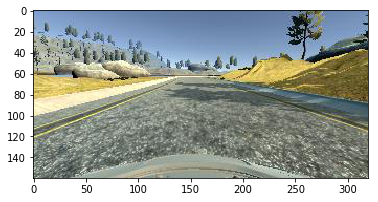

In [6]:
print("converting to train array")
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
cv_rgb = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

In [ ]:
_time = time.time()
X_train = np.array(images)
y_train = np.array(measures)
print("_time ",(time.time() - _time))

In [7]:
#checkpoint :
X_train_test = X_train
y_train_test = y_train

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D, Conv2D, Cropping2D

In [13]:
_time = time.time()
#model :
model = Sequential()
#normalize and mean center
model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((75,25), (0,0)), input_shape=(160,320,3)))
#LeNet
model.add(Conv2D(6,(5,5), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(6,(5,5), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(48))
model.add(Dense(1))
print("_time ",(time.time() - _time))

In [14]:
_time = time.time()
#train
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#hist = model.fit(X_train_test, y_train_test, validation_split=0.2, shuffle=True, epochs=10, verbose=1)
hist = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=10)
print("_time ",(time.time() - _time))


Train on 9632 samples, validate on 2409 samples
Epoch 1/10
9632/9632 [==============================] - 636s - loss: 0.1421 - val_loss: 0.2185

In [ ]:
print(hist.history)
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [15]:
#save
model.save('model.h5')

In [54]:
#checkpoint--------------------------------------
#load
from keras.models import load_model
continue_model = load_model('model.h5')

In [55]:
continue_model.compile(loss='mse', optimizer='adam')
continue_model.fit(X_train_test, y_train_test, validation_split=0.2, shuffle=True, epochs=4, verbose=1)

Train on 9632 samples, validate on 2409 samples
Epoch 1/4
9632/9632 [==============================] - 17s - loss: 5.1179 - val_loss: 3.8942

In [56]:
del model